# Models Evaluations on the filtered Subset
Here we comparied 3 types of algorithms: 
- FAISS KNN: Single-task Learning (k=5) VS Multi-task learning (k= 5, 7, 11)
- XGBoost: Single-task learning
- MolE : Multi-task leaning, with and without pretraining weights model (~1.2M Molecules scale)

In [18]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## Original Test set import

In [20]:
df00 = pd.read_parquet('../data/raw_filter_20/test_filter_2.parquet')

# Metrics

In [ ]:
def calculate_global_metric(df0, df1, thresholds=[6], model_name="Unknown"):
    """
    Calculate global AUC, Accuracy, Precision, Recall, F1-score, and plot ROC curves for multiple thresholds.
    ** For parquet format **
    
    Parameters:
    df0 (pd.DataFrame): Original dataset (containing true pIC50 values)
    df1 (pd.DataFrame): Predicted dataset (containing predicted pIC50 values)
    thresholds (list): List of thresholds for distinguishing active/inactive pIC50, default is [6], max 3 thresholds
    model_name (str): Model name for chart titles and labels, default is "Unknown"
    
    Returns:
    dict: Dictionary containing AUC, Accuracy, Precision, Recall, F1-score for each threshold
    """
    
    if not isinstance(thresholds, list):
        thresholds = [thresholds]
    thresholds = thresholds[:3]  
    df0 = df0.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    df0.columns = ['smiles'] + df0.columns[1:].astype(int).tolist()
    df1.columns = ['smiles'] + df1.columns[1:].astype(int).tolist()
    df = df0.merge(df1, on="smiles", suffixes=("_true", "_pred"))
    target_columns = [col for col in df.columns if col not in ["smiles"]]

    true_pIC50 = df[[col for col in target_columns if "_true" in col]].to_numpy()
    pred_pIC50 = df[[col for col in target_columns if "_pred" in col]].to_numpy()

    # Generate mask, only compute known data (non-zero)
    known_mask = (true_pIC50 != 0)
    true_pIC50 = true_pIC50[known_mask]  
    pred_pIC50 = pred_pIC50[known_mask]  

    results = {}

    plt.figure(figsize=(8, 6))

    # Iterate over each threshold, calculate classification metircs and store results for this threshold
    for threshold in thresholds:
        # Calculate true labels (1: active, 0: inactive)
        y_true = (true_pIC50 > threshold).astype(int)
        y_pred = pred_pIC50  

        # Calculate ROC and AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        global_auc = auc(fpr, tpr)


        plt.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {global_auc:.4f})')
       
        y_pred_binary = (y_pred > threshold).astype(int)
        
        accuracy = accuracy_score(y_true, y_pred_binary)
        precision = precision_score(y_true, y_pred_binary, zero_division=0)
        recall = recall_score(y_true, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true, y_pred_binary, zero_division=0)
        conf_matrix = confusion_matrix(y_true, y_pred_binary)


        results[threshold] = {
            "AUC": global_auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Confusion Matrix": conf_matrix
        }

        
        print(f"\nResults for Threshold = {threshold} ({model_name}):")
        print(f"Global AUC: {global_auc:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)

    
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Global ROC Curves ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

In [ ]:
def calculate_global_regression_metrics(df0, df1, model_name="Unknown"):
    """
    Calculate global regression metrics (MSE, RMSE, MAE, R²), including global MSE (unmasked) and masked MSE,
    and plot a scatter plot of true vs predicted values with a 45-degree diagonal line through the origin.
    Suitable for Parquet format regression tasks, excluding pIC50 values of 0 for masked metrics.

    Parameters:
    df0 (pd.DataFrame): Original dataset (containing true pIC50 values)
    df1 (pd.DataFrame): Predicted dataset (containing predicted pIC50 values)
    model_name (str): Model name for chart titles and labels, default is "Unknown"

    Returns:
    dict: Dictionary containing global MSE, masked MSE, RMSE, MAE, and R²
    """

    df0 = df0.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)

    df0.columns = ['smiles'] + df0.columns[1:].astype(int).tolist()
    df1.columns = ['smiles'] + df1.columns[1:].astype(int).tolist()


    df = df0.merge(df1, on="smiles", suffixes=("_true", "_pred"))


    target_columns = [col for col in df.columns if col not in ["smiles"]]

    true_pIC50 = df[[col for col in target_columns if "_true" in col]].to_numpy()
    pred_pIC50 = df[[col for col in target_columns if "_pred" in col]].to_numpy()

    # Calculate global MSE 
    global_mse = mean_squared_error(true_pIC50.flatten(), pred_pIC50.flatten())

    # Generate mask, only compute known data (non-zero) for masked metrics
    known_mask = (true_pIC50 != 0)
    y_true = true_pIC50[known_mask]  
    y_pred = pred_pIC50[known_mask]  
    masked_mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(masked_mse)
    mae = mean_absolute_error(y_true, y_pred)

    
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, s=10, label=f'{model_name} ')
    min_val = min(y_true.min(), y_pred.min(), 0)  
    max_val = max(y_true.max(), y_pred.max())     
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x') 
    
    plt.axis('square') 
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    plt.xlabel('True pIC50')
    plt.ylabel('Predicted pIC50')
    plt.title(f'Global True vs Predicted pIC50 ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.hist(y_true, bins=50, alpha=0.7, label="True pIC50")
    plt.hist(y_pred, bins=50, alpha=0.7, label="Predicted pIC50")
    plt.legend()
    plt.show()

    
    print("Mean of true values:", y_true.mean())
    print("Mean of predicted values:", y_pred.mean())
    print(f"Global Metrics ({model_name}):")
    print(f"Global MSE (unmasked): {global_mse:.6f}")
    print(f"Masked MSE (excluding zeros): {masked_mse:.6f}")
    print(f"RMSE (masked): {rmse:.4f}")
    print(f"MAE (masked): {mae:.4f}")

    return {
        "Global MSE": global_mse,
        "Masked MSE": masked_mse,
        "RMSE": rmse,
        "MAE": mae
    }

# Group by Target

In [ ]:
def load_target_dictionary(file_path):
    df = pd.read_csv(file_path, header=None)
    target_dict = dict(zip(df[0], df[1]))
    return target_dict

In [ ]:
def compute_auc_by_target_type(df_true, df_pred, target_dict_path, mapping_path, threshold=6):
    target_dict = load_target_dictionary(target_dict_path)
    target_mapping = pd.read_csv(mapping_path)

    target_types = ['SINGLE PROTEIN', 'CELL-LINE', 'ORGANISM', 'PROTEIN COMPLEX', 'PROTEIN FAMILY']
    target_mapping = target_mapping[target_mapping['target_type'].isin(target_types)]

    target_columns = [int(c) for c in df_true.columns if c != "smiles"]
    df_true.columns = ['smiles'] + target_columns
    df_pred.columns = ['smiles'] + target_columns

    df = df_true.merge(df_pred, on="smiles", suffixes=("_true", "_pred"))
    num_to_target = {str(v): k for k, v in target_dict.items()}

   
    true_all = []
    pred_all = []

    for col in target_columns:
        true_vals = df[f"{col}_true"].to_numpy()
        pred_vals = df[f"{col}_pred"].to_numpy()
        mask = (~np.isnan(true_vals)) & (~np.isnan(pred_vals)) & (true_vals != 0)
        true_vals = true_vals[mask]
        pred_vals = pred_vals[mask]
        if len(true_vals) == 0:
            continue
        y_true = (true_vals > threshold).astype(int)
        true_all.append(y_true)
        pred_all.append(pred_vals)

    if len(true_all) == 0:
        print("no valid samples for AUC calculation")
        overall_auc = np.nan
    else:
        true_all = np.concatenate(true_all)
        pred_all = np.concatenate(pred_all)
        if len(np.unique(true_all)) < 2:
            print("insufficient data samples for AUC calculation")
            overall_auc = np.nan
        else:
            fpr, tpr, _ = roc_curve(true_all, pred_all)
            overall_auc = auc(fpr, tpr)
            print(f"overall AUC: {overall_auc:.6f}")

    # AUC by target types
    for target_type in target_types:
        type_targets = target_mapping[target_mapping['target_type'] == target_type]['pref_name'].tolist()
        type_cols = [col for col in target_columns if num_to_target.get(str(col)) in type_targets]

        true_type = []
        pred_type = []

        for col in type_cols:
            true_vals = df[f"{col}_true"].to_numpy()
            pred_vals = df[f"{col}_pred"].to_numpy()
            mask = (~np.isnan(true_vals)) & (~np.isnan(pred_vals)) & (true_vals != 0)
            true_vals = true_vals[mask]
            pred_vals = pred_vals[mask]
            if len(true_vals) == 0:
                continue
            y_true = (true_vals > threshold).astype(int)
            true_type.append(y_true)
            pred_type.append(pred_vals)

        if len(true_type) == 0:
            print(f"{target_type} insufficient data for AUC calculation")
            continue

        true_type = np.concatenate(true_type)
        pred_type = np.concatenate(pred_type)

        if len(np.unique(true_type)) < 2:
            print(f"{target_type} insufficient data for AUC calculation")
            continue

        fpr, tpr, _ = roc_curve(true_type, pred_type)
        roc_auc = auc(fpr, tpr)
        print(f"{target_type} AUC: {roc_auc:.10f}")

    return overall_auc


In [ ]:
def calculate_mse_by_target_type2(df0, df1, target_dict_path, mapping_path, model_name="Unknown"):   
    target_dict = load_target_dictionary(target_dict_path)
    target_mapping = pd.read_csv(mapping_path)

    target_types = ['SINGLE PROTEIN', 'CELL-LINE', 'ORGANISM', 'PROTEIN COMPLEX', 'PROTEIN FAMILY']
    target_mapping = target_mapping[target_mapping['target_type'].isin(target_types)]

    df0 = df0.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    df0.columns = ['smiles'] + df0.columns[1:].astype(int).tolist()
    df1.columns = ['smiles'] + df1.columns[1:].astype(int).tolist()

    df = df0.merge(df1, on="smiles", suffixes=("_true", "_pred"))

    target_columns = [col for col in df0.columns if col != "smiles"]

    true_pIC50 = df[[f"{col}_true" for col in target_columns]].to_numpy()
    pred_pIC50 = df[[f"{col}_pred" for col in target_columns]].to_numpy()

    global_mse = np.mean((np.nan_to_num(true_pIC50, nan=0.0) - np.nan_to_num(pred_pIC50, nan=0.0)) ** 2)

    known_mask = (true_pIC50 != 0) & (~np.isnan(true_pIC50)) & (~np.isnan(pred_pIC50))
    masked_mse = np.mean((true_pIC50[known_mask] - pred_pIC50[known_mask]) ** 2) if known_mask.any() else np.nan

    print(f"\nModel: {model_name}")
    print(f"Global MSE: {global_mse:.4f}")
    print(f"Masked MSE: {masked_mse:.4f}\n")


    num_to_target = {str(v): k for k, v in target_dict.items()}

    mse_by_type_global = {}
    mse_by_type_masked = {}

    for target_type in target_types:
        type_targets = target_mapping[target_mapping['target_type'] == target_type]['pref_name'].tolist()
        type_columns = [col for col in target_columns if num_to_target.get(str(col)) in type_targets]

        if not type_columns:
            mse_by_type_global[target_type] = np.nan
            mse_by_type_masked[target_type] = np.nan
            continue

        true_type_global = np.nan_to_num(df[[f"{col}_true" for col in type_columns]].to_numpy(), nan=0.0)
        pred_type_global = np.nan_to_num(df[[f"{col}_pred" for col in type_columns]].to_numpy(), nan=0.0)

        mse_global = np.mean((true_type_global - pred_type_global) ** 2)
        mse_by_type_global[target_type] = mse_global

        true_type = df[[f"{col}_true" for col in type_columns]].to_numpy()
        pred_type = df[[f"{col}_pred" for col in type_columns]].to_numpy()
        mask = (true_type != 0) & (~np.isnan(true_type)) & (~np.isnan(pred_type))
        if mask.any():
            mse_masked = np.mean((true_type[mask] - pred_type[mask]) ** 2)
        else:
            mse_masked = np.nan
        mse_by_type_masked[target_type] = mse_masked

        print(f"Target Type: {target_type}")
        print(f"  Global MSE: {mse_global:.4f}")
        print(f"  Masked MSE: {mse_masked:.4f}\n")

    return {
        "Global MSE": global_mse,
        "Masked MSE": masked_mse,
        "MSE by Target Type Global": mse_by_type_global,
        "MSE by Target Type Masked": mse_by_type_masked
    }


In [ ]:
def calculate_mse_all(df0, df1, target_dict_path, mapping_path, model_name="Unknown"):

    target_dict = load_target_dictionary(target_dict_path)
    target_mapping = pd.read_csv(mapping_path)

 
    target_types = ['SINGLE PROTEIN', 'CELL-LINE', 'ORGANISM', 'PROTEIN COMPLEX', 'PROTEIN FAMILY']
    target_mapping = target_mapping[target_mapping['target_type'].isin(target_types)]


    df0 = df0.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    df0.columns = ['smiles'] + df0.columns[1:].astype(int).tolist()
    df1.columns = ['smiles'] + df1.columns[1:].astype(int).tolist()
    df = df0.merge(df1, on="smiles", suffixes=("_true", "_pred"))

    target_columns = [col for col in df0.columns if col != "smiles"]


    true_pIC50 = df[[f"{col}_true" for col in target_columns]].to_numpy()
    pred_pIC50 = df[[f"{col}_pred" for col in target_columns]].to_numpy()

    global_mse = np.mean((np.nan_to_num(true_pIC50, nan=0.0) - np.nan_to_num(pred_pIC50, nan=0.0)) ** 2)
    known_mask = (true_pIC50 != 0) & (~np.isnan(true_pIC50)) & (~np.isnan(pred_pIC50))
    masked_mse = np.mean((true_pIC50[known_mask] - pred_pIC50[known_mask]) ** 2) if known_mask.any() else np.nan

    print(f"\nModel: {model_name}")
    print(f"Global MSE: {global_mse:.4f}")
    print(f"Masked MSE: {masked_mse:.4f}\n")

    num_to_target = {str(v): k for k, v in target_dict.items()}

    mse_by_type_global = {}
    mse_by_type_masked = {}
    rmse_by_type = {}
    mae_by_type = {}
    mean_true_by_type = {}
    mean_pred_by_type = {}

    for target_type in target_types:
        type_targets = target_mapping[target_mapping['target_type'] == target_type]['pref_name'].tolist()
        type_columns = [col for col in target_columns if num_to_target.get(str(col)) in type_targets]

        if not type_columns:
            continue

        true_type_global = np.nan_to_num(df[[f"{col}_true" for col in type_columns]].to_numpy(), nan=0.0)
        pred_type_global = np.nan_to_num(df[[f"{col}_pred" for col in type_columns]].to_numpy(), nan=0.0)
        mse_global = np.mean((true_type_global - pred_type_global) ** 2)
        mse_by_type_global[target_type] = mse_global

        true_type = df[[f"{col}_true" for col in type_columns]].to_numpy()
        pred_type = df[[f"{col}_pred" for col in type_columns]].to_numpy()
        mask = (true_type != 0) & (~np.isnan(true_type)) & (~np.isnan(pred_type))

        if mask.any():
            y_true = true_type[mask]
            y_pred = pred_type[mask]

            mse_masked = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse_masked)
            mae = mean_absolute_error(y_true, y_pred)

            mse_by_type_masked[target_type] = mse_masked
            rmse_by_type[target_type] = rmse
            mae_by_type[target_type] = mae
            mean_true_by_type[target_type] = np.mean(y_true)
            mean_pred_by_type[target_type] = np.mean(y_pred)

            print(f"Target Type: {target_type}")
            print(f"  Global MSE: {mse_global:.4f}")
            print(f"  Masked MSE: {mse_masked:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  Mean True pIC50: {mean_true_by_type[target_type]:.4f}")
            print(f"  Mean Pred pIC50: {mean_pred_by_type[target_type]:.4f}")

           # 画直方图
            plt.figure(figsize=(6, 4))
            plt.hist(y_true, bins=50, alpha=0.6, color = "mediumslateblue", label='True pIC50')
            plt.hist(y_pred, bins=50, alpha=0.6, color = "paleturquoise", label='Predicted pIC50')
            plt.title(f'{target_type} - True vs Predicted pIC50')
            plt.xlabel('pIC50')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        else:
            mse_by_type_masked[target_type] = np.nan
            rmse_by_type[target_type] = np.nan
            mae_by_type[target_type] = np.nan
            mean_true_by_type[target_type] = np.nan
            mean_pred_by_type[target_type] = np.nan

    return {
        "Global MSE": global_mse,
        "Masked MSE": masked_mse,
        "MSE by Target Type Global": mse_by_type_global,
        "MSE by Target Type Masked": mse_by_type_masked,
        "RMSE by Target Type": rmse_by_type,
        "MAE by Target Type": mae_by_type,
        "Mean True by Target Type": mean_true_by_type,
        "Mean Pred by Target Type": mean_pred_by_type
    }

# Model Evaluations

## 1. MolE without pretrained 

In [21]:
df1 = pd.read_parquet('../data/results/predictions_MolE_filter.parquet')


Model: MolE
Global MSE: 0.0134
Masked MSE: 21.1970

Target Type: SINGLE PROTEIN
  Global MSE: 0.0140
  Masked MSE: 21.6976
  RMSE: 4.6581
  MAE: 3.8386
  Mean True pIC50: 6.5714
  Mean Pred pIC50: 2.8129


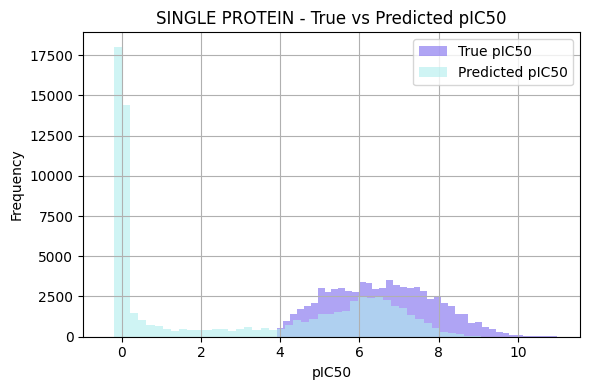

Target Type: CELL-LINE
  Global MSE: 0.0110
  Masked MSE: 19.0258
  RMSE: 4.3619
  MAE: 3.6632
  Mean True pIC50: 5.5477
  Mean Pred pIC50: 1.9454


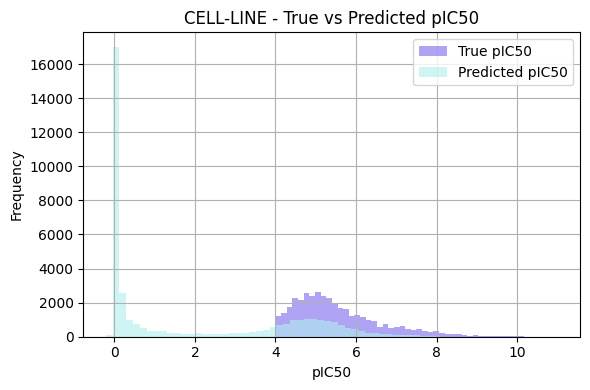

Target Type: ORGANISM
  Global MSE: 0.0198
  Masked MSE: 21.0647
  RMSE: 4.5896
  MAE: 3.9082
  Mean True pIC50: 5.9045
  Mean Pred pIC50: 2.0825


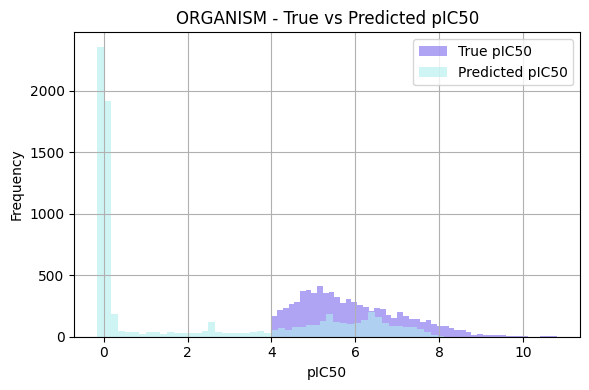

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0130
  Masked MSE: 28.3502
  RMSE: 5.3245
  MAE: 4.8733
  Mean True pIC50: 6.5575
  Mean Pred pIC50: 1.7189


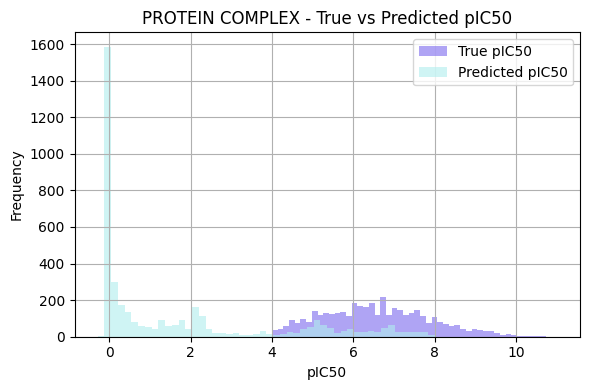

Target Type: PROTEIN FAMILY
  Global MSE: 0.0149
  Masked MSE: 27.6948
  RMSE: 5.2626
  MAE: 4.5646
  Mean True pIC50: 6.5902
  Mean Pred pIC50: 2.0889


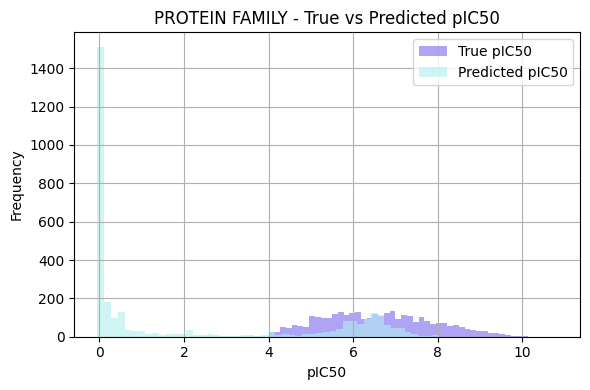

In [27]:
results = calculate_mse_all(
    df00, df1,
    target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="MolE"
)


Results for Threshold = 5 (MolE(filter, without pretrained)):
Global AUC: 0.6359
Accuracy: 0.4693
Precision: 0.9530
Recall: 0.3355
F1-score: 0.4962
Confusion Matrix:
[[27089  1680]
 [67480 34064]]

Results for Threshold = 6 (MolE(filter, without pretrained)):
Global AUC: 0.6618
Accuracy: 0.6389
Precision: 0.9186
Recall: 0.3035
F1-score: 0.4562
Confusion Matrix:
[[63511  1749]
 [45310 19743]]

Results for Threshold = 7 (MolE(filter, without pretrained)):
Global AUC: 0.6745
Accuracy: 0.7609
Precision: 0.8682
Recall: 0.1747
F1-score: 0.2909
Confusion Matrix:
[[92765   970]
 [30188  6390]]


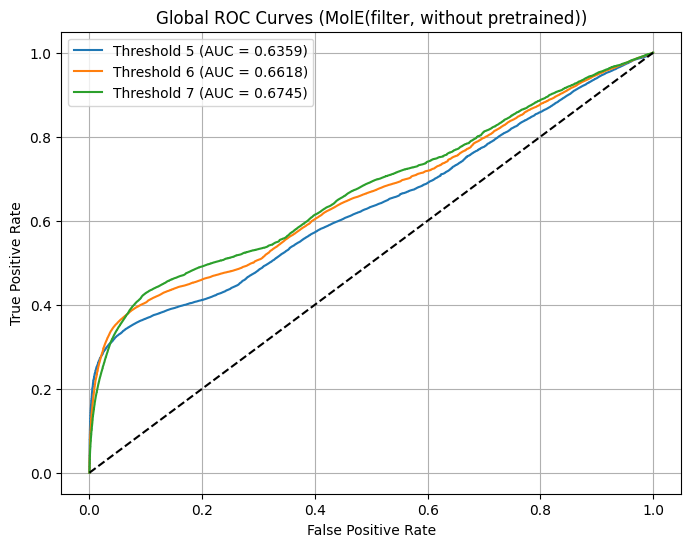

In [9]:
metrics = calculate_global_metric(df00, df1, thresholds=[5,6,7], model_name="MolE(filter, without pretrained)")

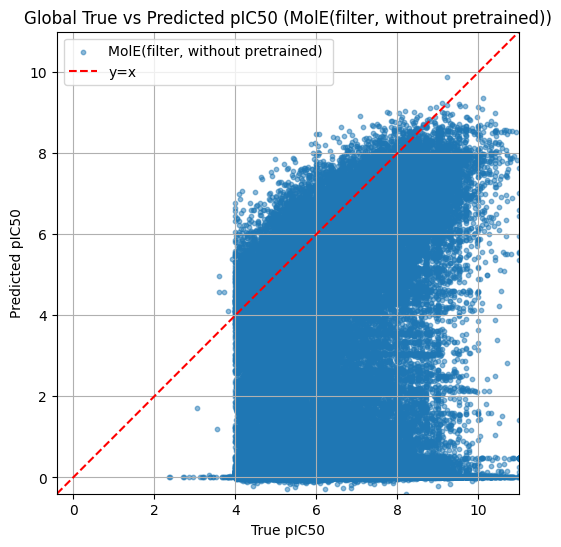

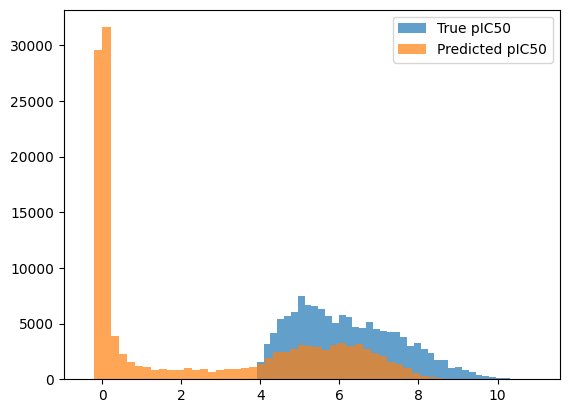

Mean of true values: 6.193532346237403
Mean of predicted values: 2.4257722
Global Metrics (MolE(filter, without pretrained)):
Global MSE (unmasked): 0.013368
Masked MSE (excluding zeros): 21.196960
RMSE (masked): 4.6040
MAE (masked): 3.8399


In [10]:
results = calculate_global_regression_metrics(df00, df1, model_name="MolE(filter, without pretrained)")

In [13]:
results = calculate_mse_by_target_type2(
    df00, df1,
    target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="MolE"
)


Model: MolE
Global MSE: 0.0134
Masked MSE: 21.1970

Target Type: SINGLE PROTEIN
  Global MSE: 0.0140
  Masked MSE: 21.6976

Target Type: CELL-LINE
  Global MSE: 0.0110
  Masked MSE: 19.0258

Target Type: ORGANISM
  Global MSE: 0.0198
  Masked MSE: 21.0647

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0130
  Masked MSE: 28.3502

Target Type: PROTEIN FAMILY
  Global MSE: 0.0149
  Masked MSE: 27.6948



In [16]:
results = compute_auc_by_target_type(df00, df1,target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv", threshold = 6)

整体AUC: 0.661752
SINGLE PROTEIN AUC: 0.7066488208
CELL-LINE AUC: 0.5743021071
ORGANISM AUC: 0.6939865231
PROTEIN COMPLEX AUC: 0.6649276780
PROTEIN FAMILY AUC: 0.6753734125


## 2. MolE with pretrained 

In [14]:
df2 =  pd.read_parquet('../data/results/predictions_MolE_pre_filter.parquet')


Results for Threshold = 5 (MolE_pretrained_filter):
Global AUC: 0.6340
Accuracy: 0.4687
Precision: 0.9475
Recall: 0.3369
F1-score: 0.4970
Confusion Matrix:
[[26875  1894]
 [67338 34206]]

Results for Threshold = 6 (MolE_pretrained_filter):
Global AUC: 0.6565
Accuracy: 0.6405
Precision: 0.9021
Recall: 0.3139
F1-score: 0.4658
Confusion Matrix:
[[63045  2215]
 [44632 20421]]

Results for Threshold = 7 (MolE_pretrained_filter):
Global AUC: 0.6668
Accuracy: 0.7617
Precision: 0.8601
Recall: 0.1804
F1-score: 0.2982
Confusion Matrix:
[[92662  1073]
 [29980  6598]]


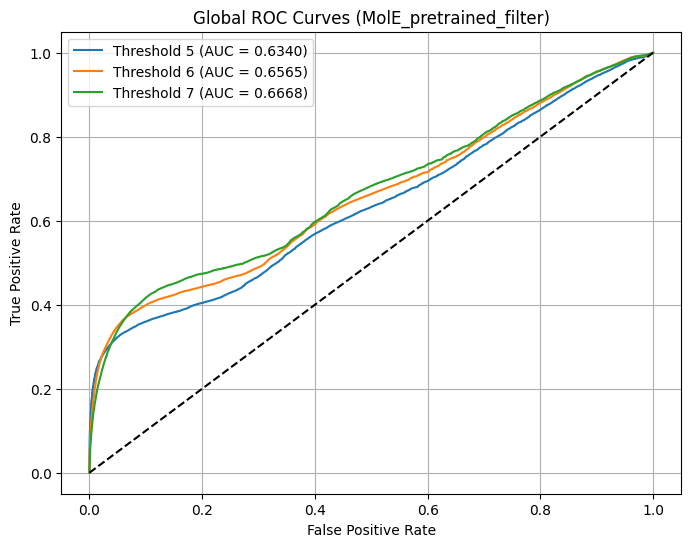

In [9]:
metrics = calculate_global_metric(df00, df2, thresholds=[5,6,7], model_name="MolE_pretrained_filter")

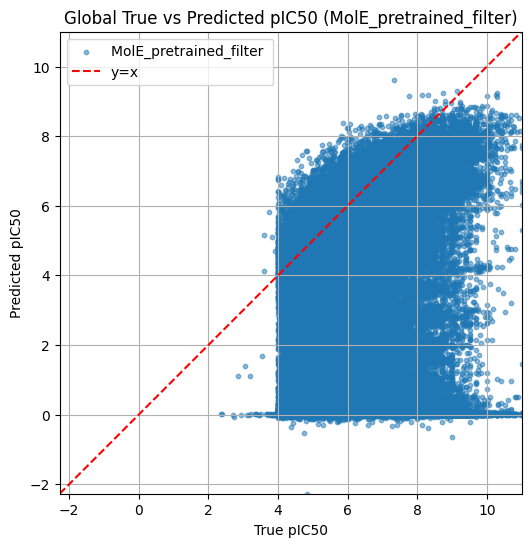

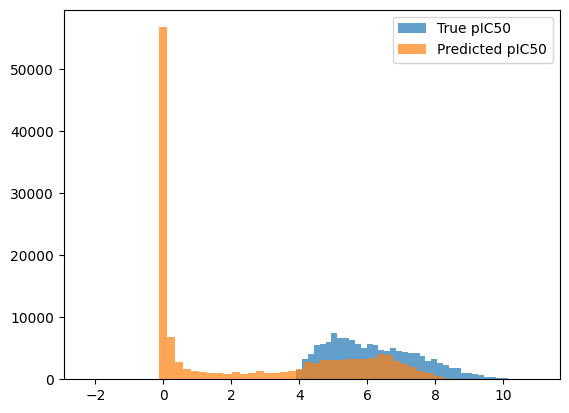

Mean of true values: 6.193532346237403
Mean of predicted values: 2.4639008
Global Metrics (MolE_pretrained_filter):
Global MSE (unmasked): 0.013394
Masked MSE (excluding zeros): 21.135290
RMSE (masked): 4.5973
MAE (masked): 3.8133


In [10]:
results2 = calculate_global_regression_metrics(df00, df2, model_name="MolE_pretrained_filter")

In [15]:
results = calculate_mse_by_target_type2(
    df00, df2,
    target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="MolE"
)


Model: MolE
Global MSE: 0.0134
Masked MSE: 21.1353

Target Type: SINGLE PROTEIN
  Global MSE: 0.0143
  Masked MSE: 22.0766

Target Type: CELL-LINE
  Global MSE: 0.0108
  Masked MSE: 18.3612

Target Type: ORGANISM
  Global MSE: 0.0196
  Masked MSE: 20.9446

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0127
  Masked MSE: 27.2588

Target Type: PROTEIN FAMILY
  Global MSE: 0.0149
  Masked MSE: 27.6337



In [18]:
results = compute_auc_by_target_type(df00, df2,target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv", threshold = 6)

整体AUC: 0.656532
SINGLE PROTEIN AUC: 0.6998780547
CELL-LINE AUC: 0.5810860800
ORGANISM AUC: 0.6882008184
PROTEIN COMPLEX AUC: 0.6605575729
PROTEIN FAMILY AUC: 0.6709285906


## 3. Online Random Forest #TODO

In [20]:
df3 = pd.read_parquet('../data/results/predictions_RF_online.parquet')


Results for Threshold = 5 (Random Forest):
Global AUC: 0.5403
Accuracy: 0.2393
Precision: 0.9933
Recall: 0.0170
F1-score: 0.0335
Confusion Matrix:
[[ 30517     12]
 [102659   1778]]

Results for Threshold = 6 (Random Forest):
Global AUC: 0.5452
Accuracy: 0.5145
Precision: 0.9265
Recall: 0.0146
F1-score: 0.0288
Confusion Matrix:
[[68469    77]
 [65450   970]]

Results for Threshold = 7 (Random Forest):
Global AUC: 0.5559
Accuracy: 0.7309
Precision: 0.8801
Recall: 0.0124
F1-score: 0.0244
Confusion Matrix:
[[98194    62]
 [36255   455]]


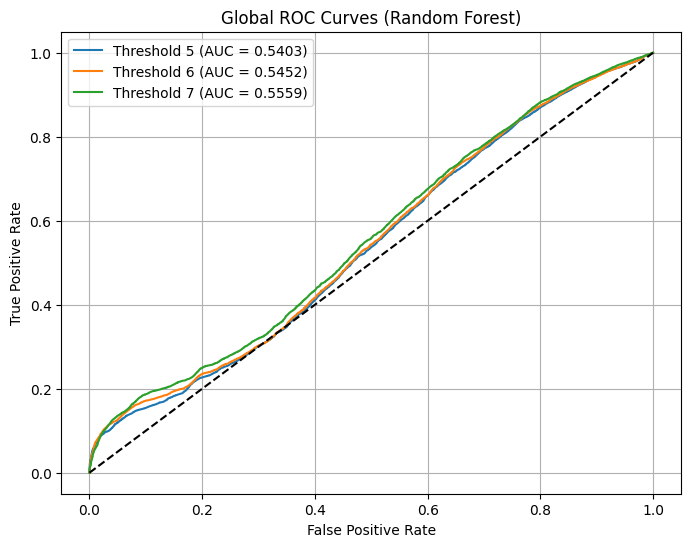

In [11]:
metrics = calculate_global_metric(df00, df3, thresholds=[5,6,7], model_name="Random Forest")

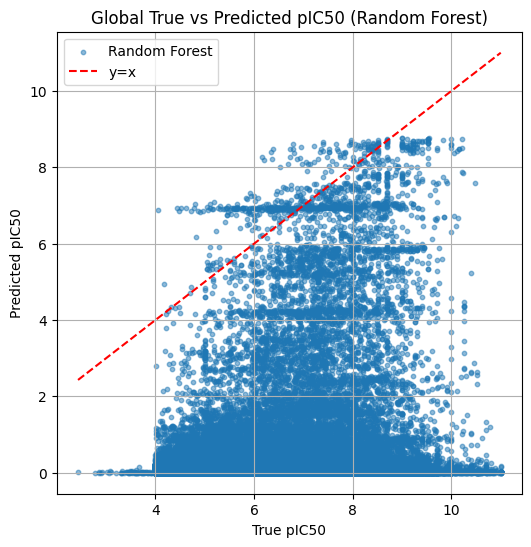

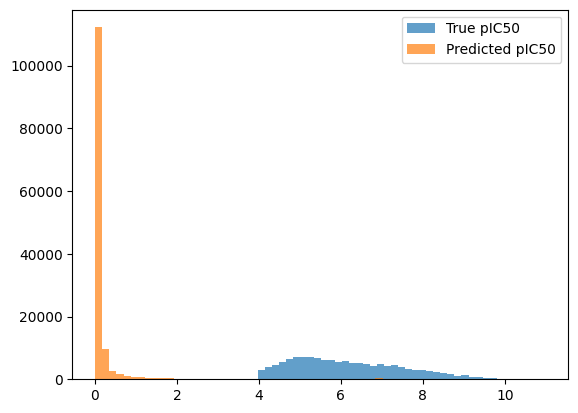

Mean of true values: 6.171844022755179
Mean of predicted values: 0.24566914338815704
Global Metrics (Random Forest):
Global MSE (unmasked): 0.010715
Masked MSE (excluding zeros): 37.299265
RMSE (masked): 6.1073
MAE (masked): 5.9297


In [38]:
results3 = calculate_global_regression_metrics(df00, df3, model_name="Random Forest")

In [ ]:
results = calculate_mse_by_target_type2(
    df00, df3,
    target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="MolE"
)


Model: MolE
Global MSE: 0.0246
Masked MSE: 40.6033

Target Type: SINGLE PROTEIN
  Global MSE: 0.0255
  Masked MSE: 40.7016

Target Type: CELL-LINE
  Global MSE: 0.0214
  Masked MSE: 39.8154

Target Type: ORGANISM
  Global MSE: 0.0196
  Masked MSE: 42.5999

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0203
  Masked MSE: 41.1698

Target Type: PROTEIN FAMILY
  Global MSE: 0.0422
  Masked MSE: 40.1807



In [ ]:
results = compute_auc_by_target_type(df00, df2,target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv", threshold = 6)

整体AUC: 0.656532
SINGLE PROTEIN AUC: 0.6621740010
CELL-LINE AUC: 0.6221307051
ORGANISM AUC: 0.6845525065
PROTEIN COMPLEX AUC: 0.6966589054
PROTEIN FAMILY AUC: 0.7106009183


## 4. KNN

### Multi-tasks learning

In [28]:
df4 = pd.read_parquet('../data/results/predictions_KNN_filter.parquet')


Model: MolE
Global MSE: 0.0071
Masked MSE: 7.3126

Target Type: SINGLE PROTEIN
  Global MSE: 0.0057
  Masked MSE: 5.9044
  RMSE: 2.4299
  MAE: 1.5650
  Mean True pIC50: 6.5714
  Mean Pred pIC50: 5.3245


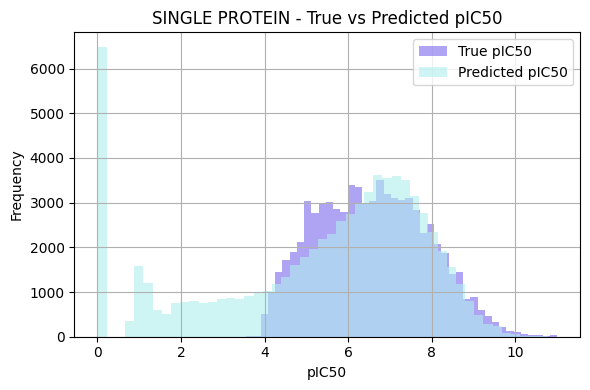

Target Type: CELL-LINE
  Global MSE: 0.0089
  Masked MSE: 9.7555
  RMSE: 3.1234
  MAE: 2.2994
  Mean True pIC50: 5.5477
  Mean Pred pIC50: 3.3821


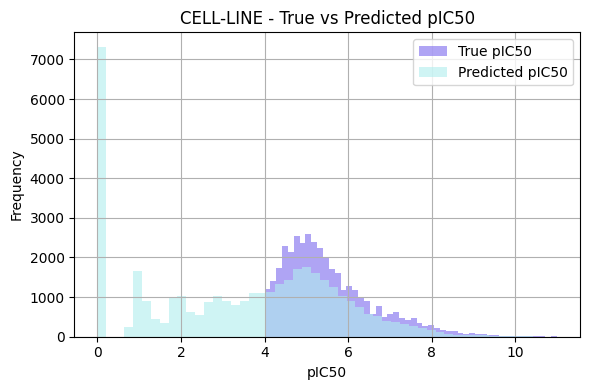

Target Type: ORGANISM
  Global MSE: 0.0120
  Masked MSE: 8.5160
  RMSE: 2.9182
  MAE: 2.0962
  Mean True pIC50: 5.9045
  Mean Pred pIC50: 3.9962


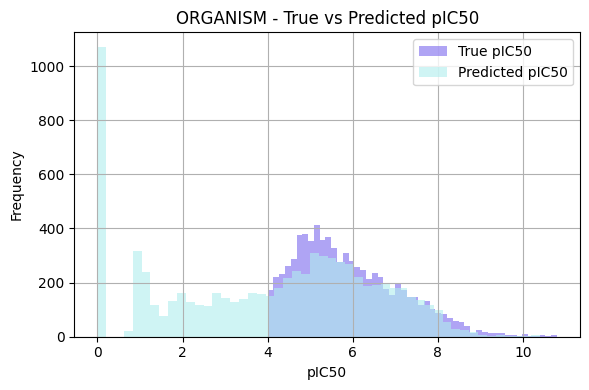

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0048
  Masked MSE: 6.4980
  RMSE: 2.5491
  MAE: 1.6952
  Mean True pIC50: 6.5575
  Mean Pred pIC50: 5.1887


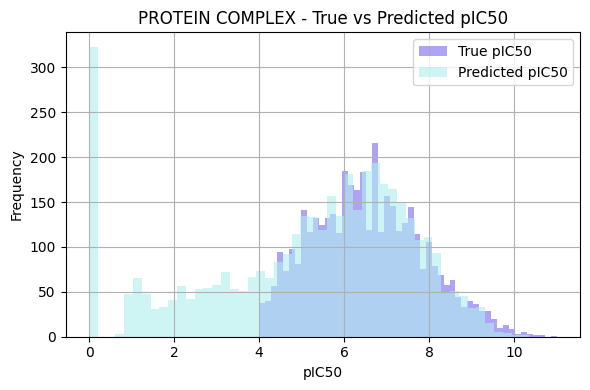

Target Type: PROTEIN FAMILY
  Global MSE: 0.0064
  Masked MSE: 7.0368
  RMSE: 2.6527
  MAE: 1.8051
  Mean True pIC50: 6.5902
  Mean Pred pIC50: 5.0705


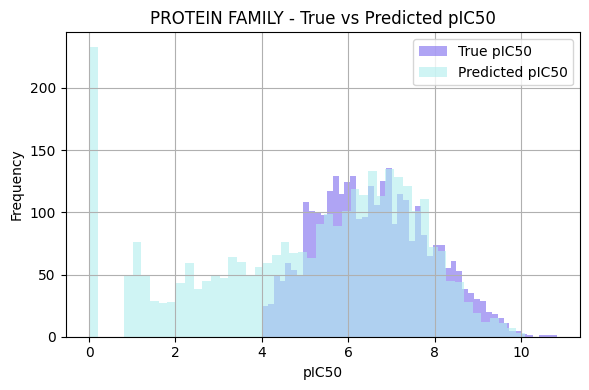

In [29]:
results = calculate_mse_all(
    df00, df4,
    target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="MolE"
)


Results for Threshold = 5 (KNN):
Global AUC: 0.7777
Accuracy: 0.6834
Precision: 0.9480
Recall: 0.6282
F1-score: 0.7556
Confusion Matrix:
[[25271  3498]
 [37757 63787]]

Results for Threshold = 6 (KNN):
Global AUC: 0.8160
Accuracy: 0.7863
Precision: 0.8929
Recall: 0.6498
F1-score: 0.7522
Confusion Matrix:
[[60189  5071]
 [22782 42271]]

Results for Threshold = 7 (KNN):
Global AUC: 0.8310
Accuracy: 0.8527
Precision: 0.8205
Recall: 0.6085
F1-score: 0.6988
Confusion Matrix:
[[88865  4870]
 [14319 22259]]


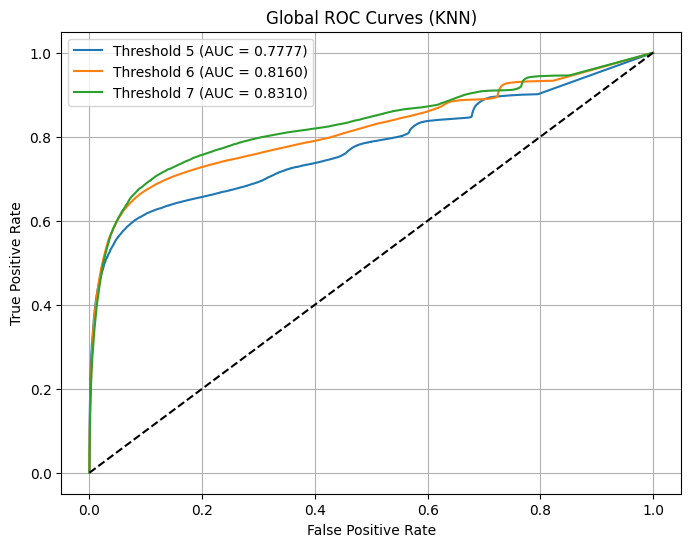

In [7]:
metrics = calculate_global_metric(df00, df4, thresholds=[5,6,7], model_name="KNN")

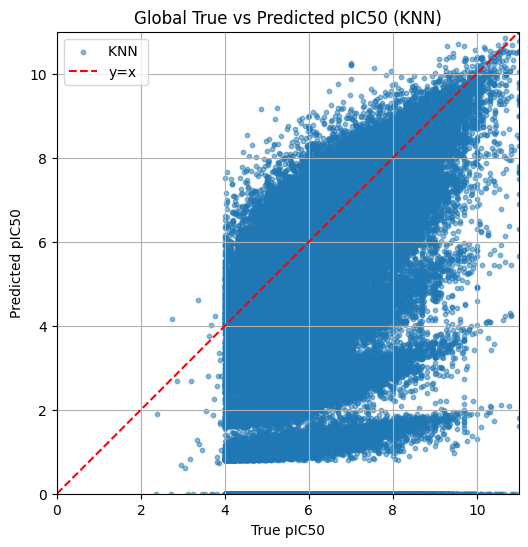

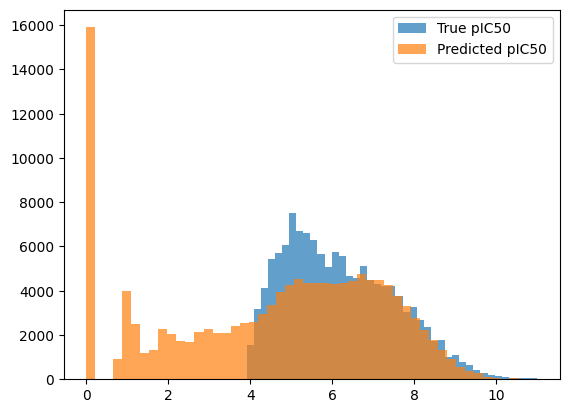

Mean of true values: 6.193532346237403
Mean of predicted values: 4.6016517
Global Metrics (KNN):
Global MSE (unmasked): 0.007124
Masked MSE (excluding zeros): 7.312643
RMSE (masked): 2.7042
MAE (masked): 1.8406


In [8]:
results4 = calculate_global_regression_metrics(df00, df4, model_name="KNN")

In [20]:
results = compute_auc_by_target_type(df00, df4,target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv", threshold = 6)

整体AUC: 0.816010
SINGLE PROTEIN AUC: 0.8442265593
CELL-LINE AUC: 0.6682972366
ORGANISM AUC: 0.7630323999
PROTEIN COMPLEX AUC: 0.7732953892
PROTEIN FAMILY AUC: 0.7945502914


In [21]:
results = calculate_mse_by_target_type2(
    df00, df4,
    target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="MolE"
)


Model: MolE
Global MSE: 0.0071
Masked MSE: 7.3126

Target Type: SINGLE PROTEIN
  Global MSE: 0.0057
  Masked MSE: 5.9044

Target Type: CELL-LINE
  Global MSE: 0.0089
  Masked MSE: 9.7555

Target Type: ORGANISM
  Global MSE: 0.0120
  Masked MSE: 8.5160

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0048
  Masked MSE: 6.4980

Target Type: PROTEIN FAMILY
  Global MSE: 0.0064
  Masked MSE: 7.0368



### KNN, K=7

In [6]:
df47 = pd.read_parquet("predictions_KNN7_filter.parquet")


Results for Threshold = 5 (KNN, k=7):
Global AUC: 0.7732
Accuracy: 0.6637
Precision: 0.9534
Recall: 0.5976
F1-score: 0.7347
Confusion Matrix:
[[25803  2966]
 [40862 60682]]

Results for Threshold = 6 (KNN, k=7):
Global AUC: 0.8110
Accuracy: 0.7753
Precision: 0.8994
Recall: 0.6192
F1-score: 0.7334
Confusion Matrix:
[[60754  4506]
 [24773 40280]]

Results for Threshold = 7 (KNN, k=7):
Global AUC: 0.8249
Accuracy: 0.8469
Precision: 0.8284
Recall: 0.5733
F1-score: 0.6776
Confusion Matrix:
[[89390  4345]
 [15607 20971]]


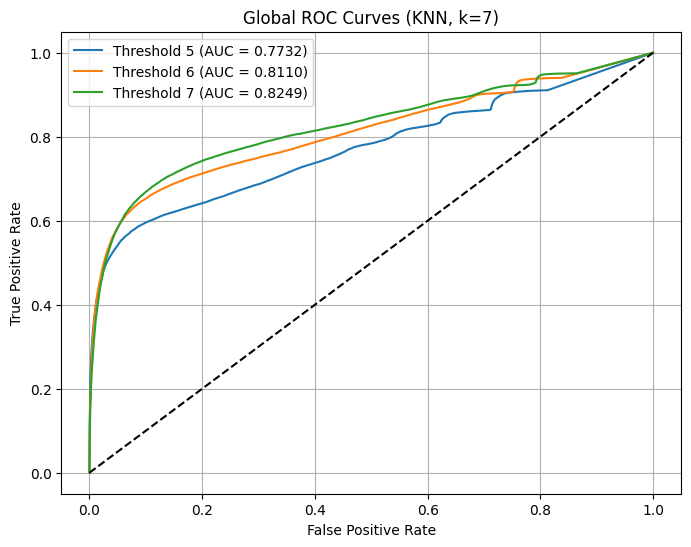

In [8]:
metrics = calculate_global_metric(df00, df47, thresholds=[5,6,7], model_name="KNN, k=7")

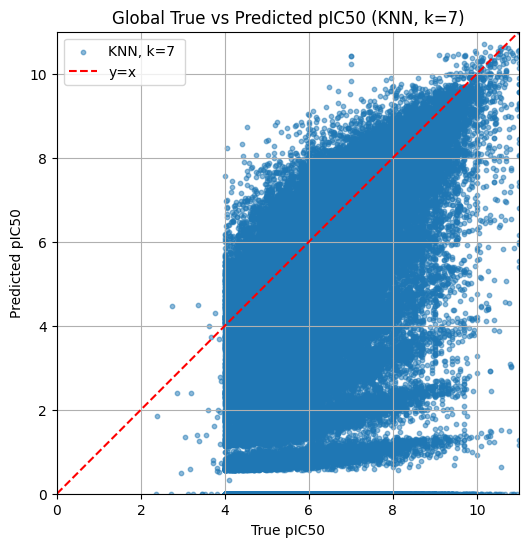

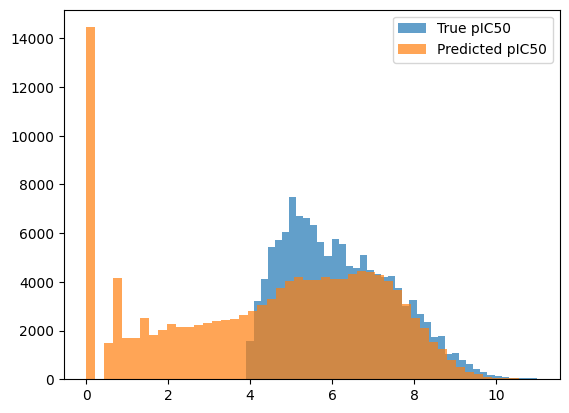

Mean of true values: 6.193532346237403
Mean of predicted values: 4.461859
Global Metrics (KNN, k=7):
Global MSE (unmasked): 0.007083
Masked MSE (excluding zeros): 7.726816
RMSE (masked): 2.7797
MAE (masked): 1.9500


In [7]:
results4 = calculate_global_regression_metrics(df00, df47, model_name="KNN, k=7")

In [7]:
results = compute_auc_by_target_type(df00, df47,target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv", threshold = 6)

整体AUC: 0.811024
SINGLE PROTEIN AUC: 0.8390462322
CELL-LINE AUC: 0.6624135663
ORGANISM AUC: 0.7540559959
PROTEIN COMPLEX AUC: 0.7651475126
PROTEIN FAMILY AUC: 0.7899616783


In [9]:
results = calculate_mse_by_target_type2(
    df00, df47,
    target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="MolE"
)


Model: MolE
Global MSE: 0.0071
Masked MSE: 7.7268

Target Type: SINGLE PROTEIN
  Global MSE: 0.0058
  Masked MSE: 6.2550

Target Type: CELL-LINE
  Global MSE: 0.0087
  Masked MSE: 10.2535

Target Type: ORGANISM
  Global MSE: 0.0121
  Masked MSE: 9.0340

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0049
  Masked MSE: 6.9019

Target Type: PROTEIN FAMILY
  Global MSE: 0.0064
  Masked MSE: 7.5001



### KNN, k=11

In [10]:
df411 = pd.read_parquet("predictions_KNN11_filter.parquet")


Results for Threshold = 5 (KNN, k=11):
Global AUC: 0.7652
Accuracy: 0.6262
Precision: 0.9605
Recall: 0.5427
F1-score: 0.6935
Confusion Matrix:
[[26500  2269]
 [46441 55103]]

Results for Threshold = 6 (KNN, k=11):
Global AUC: 0.8010
Accuracy: 0.7520
Precision: 0.9054
Recall: 0.5619
F1-score: 0.6935
Confusion Matrix:
[[61440  3820]
 [28497 36556]]

Results for Threshold = 7 (KNN, k=11):
Global AUC: 0.8122
Accuracy: 0.8348
Precision: 0.8353
Recall: 0.5125
F1-score: 0.6353
Confusion Matrix:
[[90039  3696]
 [17831 18747]]


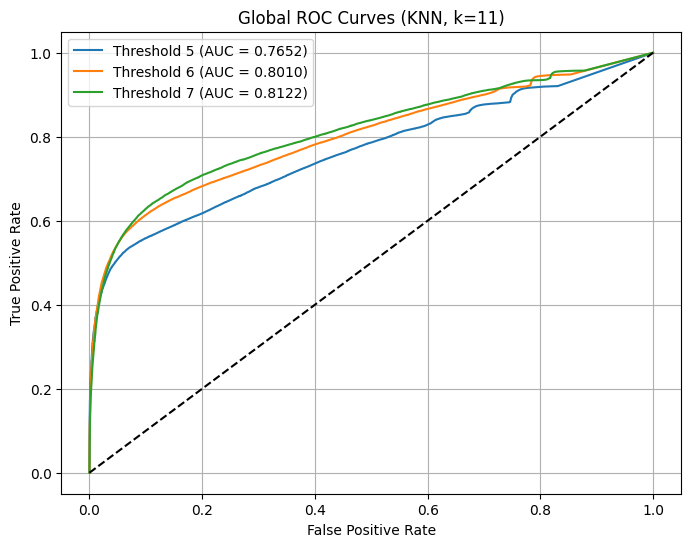

In [11]:
metrics = calculate_global_metric(df00, df411, thresholds=[5,6,7], model_name="KNN, k=11")

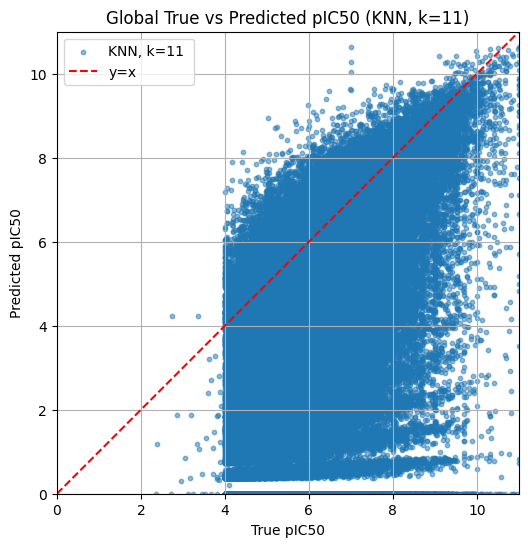

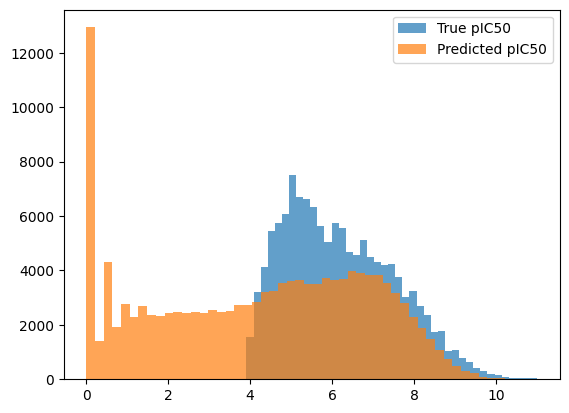

Mean of true values: 6.193532346237403
Mean of predicted values: 4.211247
Global Metrics (KNN, k=11):
Global MSE (unmasked): 0.007299
Masked MSE (excluding zeros): 8.633065
RMSE (masked): 2.9382
MAE (masked): 2.1604


In [13]:
results4 = calculate_global_regression_metrics(df00, df411, model_name="KNN, k=11")

In [11]:
results = compute_auc_by_target_type(df00, df411,target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv", threshold = 6)

整体AUC: 0.800952
SINGLE PROTEIN AUC: 0.8277146586
CELL-LINE AUC: 0.6503007877
ORGANISM AUC: 0.7450059127
PROTEIN COMPLEX AUC: 0.7517139878
PROTEIN FAMILY AUC: 0.7807312980


In [12]:
results = calculate_mse_by_target_type2(
    df00, df411,
    target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="MolE"
)


Model: MolE
Global MSE: 0.0073
Masked MSE: 8.6331

Target Type: SINGLE PROTEIN
  Global MSE: 0.0061
  Masked MSE: 7.0451

Target Type: CELL-LINE
  Global MSE: 0.0086
  Masked MSE: 11.3102

Target Type: ORGANISM
  Global MSE: 0.0127
  Masked MSE: 10.0772

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0051
  Masked MSE: 7.7038

Target Type: PROTEIN FAMILY
  Global MSE: 0.0067
  Masked MSE: 8.5121



### Single-task learning

In [5]:
df4s = pd.read_parquet('../data/results/prediction_KNN_f_STL.parquet')


Results for Threshold = 5 (KNN-STL):
Global AUC: 0.7777
Accuracy: 0.6834
Precision: 0.9480
Recall: 0.6282
F1-score: 0.7556
Confusion Matrix:
[[25271  3498]
 [37757 63787]]

Results for Threshold = 6 (KNN-STL):
Global AUC: 0.8160
Accuracy: 0.7863
Precision: 0.8929
Recall: 0.6498
F1-score: 0.7522
Confusion Matrix:
[[60189  5071]
 [22782 42271]]

Results for Threshold = 7 (KNN-STL):
Global AUC: 0.8310
Accuracy: 0.8527
Precision: 0.8205
Recall: 0.6085
F1-score: 0.6988
Confusion Matrix:
[[88865  4870]
 [14319 22259]]


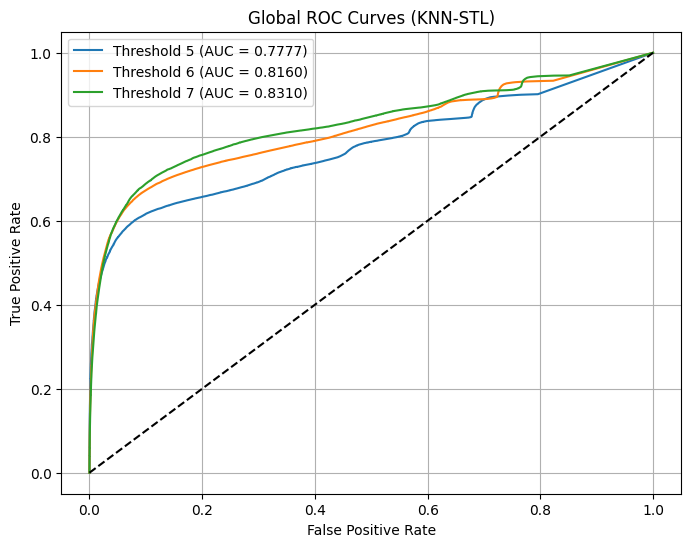

In [6]:
metrics = calculate_global_metric(df00, df4s, thresholds=[5,6,7], model_name="KNN-STL")

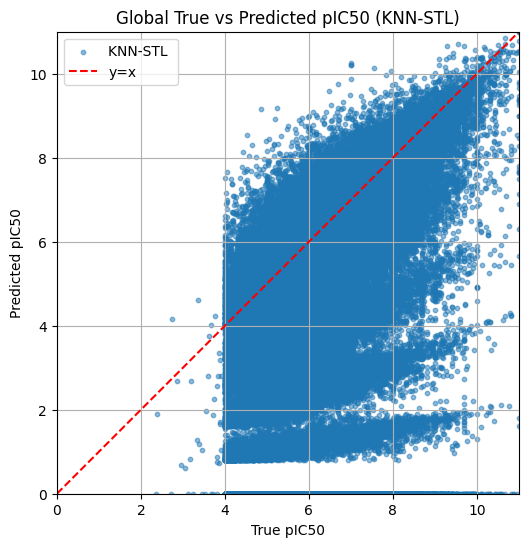

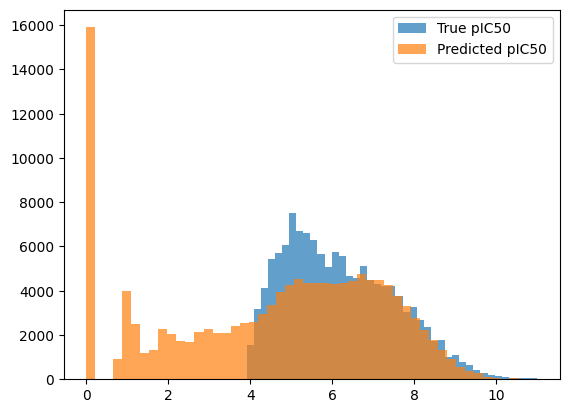

Mean of true values: 6.193532346237403
Mean of predicted values: 4.6016517
Global Metrics (KNN-STL):
Global MSE (unmasked): 0.007124
Masked MSE (excluding zeros): 7.312643
RMSE (masked): 2.7042
MAE (masked): 1.8406


In [7]:
results4s = calculate_global_regression_metrics(df00, df4s, model_name="KNN-STL")

## 5. XGBoost 

In [22]:
df5  =pd.read_parquet("../data/results/predictions_XGB_filter_STL.parquet")


Results for Threshold = 5 (XGBoost(STL)):
Global AUC: 0.7635
Accuracy: 0.5860
Precision: 0.9726
Recall: 0.4823
F1-score: 0.6448
Confusion Matrix:
[[27391  1378]
 [52570 48974]]

Results for Threshold = 6 (XGBoost(STL)):
Global AUC: 0.7998
Accuracy: 0.7357
Precision: 0.9269
Recall: 0.5109
F1-score: 0.6587
Confusion Matrix:
[[62638  2622]
 [31816 33237]]

Results for Threshold = 7 (XGBoost(STL)):
Global AUC: 0.8115
Accuracy: 0.8288
Precision: 0.8584
Recall: 0.4673
F1-score: 0.6052
Confusion Matrix:
[[90915  2820]
 [19484 17094]]


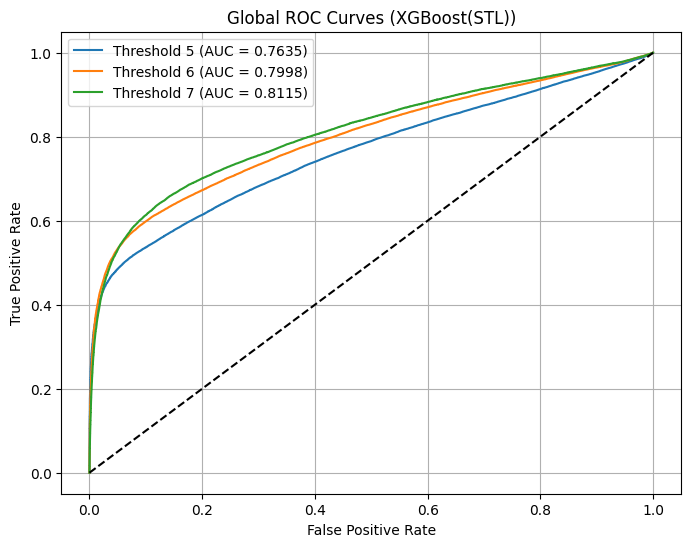

In [7]:
metrics = calculate_global_metric(df00, df5, thresholds=[5,6,7], model_name="XGBoost(STL)")

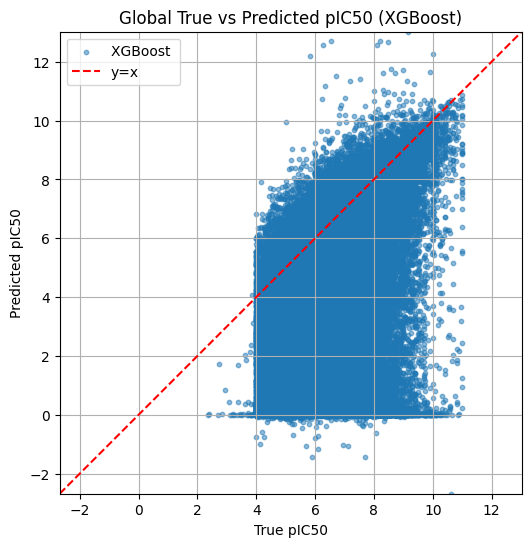

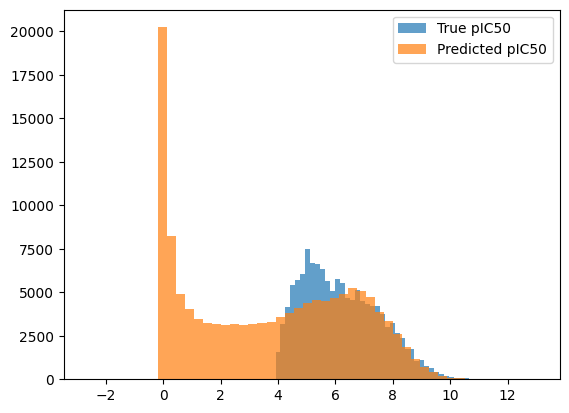

Mean of true values: 6.193532346237403
Mean of predicted values: 3.7010472
Global Metrics (XGBoost):
Global MSE (unmasked): 0.008239
Masked MSE (excluding zeros): 11.529728
RMSE (masked): 3.3955
MAE (masked): 2.6291


In [8]:
results5 = calculate_global_regression_metrics(df00, df5, model_name="XGBoost")

In [23]:
results = calculate_mse_by_target_type2(
    df00, df5,
    target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="MolE"
)


Model: MolE
Global MSE: 0.0082
Masked MSE: 11.5297

Target Type: SINGLE PROTEIN
  Global MSE: 0.0066
  Masked MSE: 8.5050

Target Type: CELL-LINE
  Global MSE: 0.0100
  Masked MSE: 16.1478

Target Type: ORGANISM
  Global MSE: 0.0150
  Masked MSE: 14.9750

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0053
  Masked MSE: 8.5695

Target Type: PROTEIN FAMILY
  Global MSE: 0.0068
  Masked MSE: 9.7459



In [24]:
results = compute_auc_by_target_type(df00, df5,target_dict_path="../data/raw_filter_20/target_to_index.csv",
    mapping_path="../data/raw/target_mapping.csv", threshold = 6)

整体AUC: 0.799776
SINGLE PROTEIN AUC: 0.8235649592
CELL-LINE AUC: 0.6417852172
ORGANISM AUC: 0.7054703877
PROTEIN COMPLEX AUC: 0.7689172039
PROTEIN FAMILY AUC: 0.7793164686
